In [47]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import re
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
from collections import Counter
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:00, 1667.14it/s]


#  –î–æ–º–∞—à–Ω–µ–µ –∑–∞–¥–∞–Ω–∏–µ –ø–æ NLP # 1 [100 –±–∞–ª–ª–æ–≤]
## –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ 

–í —ç—Ç–æ–º –¥–æ–º–∞—à–Ω–µ–º –∑–∞–¥–∞–Ω–∏–∏ –≤–∞–º –ø—Ä–µ–¥—Å—Ç–æ–∏—Ç –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ –æ—Ç–∑—ã–≤—ã –Ω–∞ –±–∞–Ω–∫–∏ —Å —Å–∞–π—Ç–∞ banki.ru.

–î–∞–Ω–Ω—ã–µ —Å–æ–¥–µ—Ä–∂–∞—Ç –Ω–µ–ø–æ—Å—Ä–µ–¥—Å—Ç–≤–µ–Ω–Ω–æ —Ç–µ–∫—Å—Ç—ã –æ—Ç–∑—ã–≤–æ–≤, –Ω–µ–∫–æ—Ç–æ—Ä—É—é –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é, –∞ —Ç–∞–∫–∂–µ –æ—Ü–µ–Ω–∫—É –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5. 

–¢–µ–∫—Å—Ç—ã —Ö—Ä–∞–Ω—è—Ç—Å—è –≤ json-–∞—Ö –≤ –º–∞—Å—Å–∏–≤–µ responses.

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø—Ä–∏–º–µ—Ä –æ—Ç–∑—ã–≤–∞:

In [5]:
responses[99]

{'city': '–≥. –°–∞—Ä–∞—Ç–æ–≤',
 'rating_not_checked': False,
 'title': '–ö–∞—Ä—Ç–∞ –∫–æ –≤–∫–ª–∞–¥—É',
 'num_comments': 0,
 'bank_license': '–ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 880',
 'author': 'ronnichka',
 'bank_name': '–Æ–≥—Ä–∞',
 'datetime': '2015-06-03 20:56:57',
 'text': '–ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –•–æ—Ç–µ–ª–∞ –Ω–∞–ø–∏—Å–∞—Ç—å, —á—Ç–æ –º–Ω–µ –º–µ—Å—è—Ü –Ω–µ –≤—ã–¥–∞—é—Ç –∫–∞—Ä—Ç—É –∫–æ –≤–∫–ª–∞–¥—É, —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ "–Ω–∞–º –∂–µ –∏—Ö –∏–∑ –°–∞–º–∞—Ä—ã –≤–µ–∑—É—Ç" (–Ω–∞ —Å–µ–∫—É–Ω–¥–æ—á–∫—É 5 —á–∞—Å–æ–≤ –µ–∑–¥—ã –æ—Ç –Ω–∞—à–µ–≥–æ –≥–æ—Ä–æ–¥–∞). –ù–æ! –ü—Ä–æ—á–∏—Ç–∞–ª–∞, —á—Ç–æ –ª—é–¥—è–º 3,5 –º–µ—Å—è—Ü–µ–≤ –Ω–µ –≤—ã–¥–∞—é—Ç –∫–∞—Ä—Ç—É, –∏ –ø–æ–Ω—è–ª–∞, —á—Ç–æ —É –º–µ–Ω—è –≤—Å–µ —Ö–æ—Ä–æ—à–æ, –ø–æ–∫–∞ —á—Ç–æ. –ò –ø–æ–¥–∞—Ä–æ–∫ –º–Ω–µ –¥–∞–ª–∏, –∏ –∫—É–ª–µ—Ä –≤ –æ—Ç–¥–µ–ª–µ–Ω–∏–∏ –µ—Å—Ç—å. –¢–∞–∫ —á—Ç–æ —è, –∫–æ–Ω–µ—á–Ω–æ, –≥–æ—Ç–æ–≤–∞ –∂–¥–∞—Ç—å. –ü—Ä–∞–≤–¥–∞ —Ö–æ—Ç–µ–ª–æ—Å—å –±—ã –Ω–µ –æ—á–µ–Ω—å –¥–æ–ª–≥–æ.',
 'rating_grade': 3}

## –ß–∞—Å—Ç—å 1. –ê–Ω–∞–ª–∏–∑ —Ç–µ–∫—Å—Ç–æ–≤ [40/100]

1. –ü–æ—Å—á–∏—Ç–∞–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤ –≤ —Ä–∞–∑–Ω—ã—Ö –≥–æ—Ä–æ–¥–∞—Ö –∏ –Ω–∞ —Ä–∞–∑–Ω—ã–µ –±–∞–Ω–∫–∏
2. –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –≥–∏—Å—Ç–æ–≥—Ä–∞–º—ã –¥–ª–∏–Ω —Å–ª–æ–≤ –≤ —Å–∏–º–≤–æ–ª–∞—Ö –∏ –≤ —Å–ª–æ–≤–∞—Ö
3. –ù–∞–π–¥–∏—Ç–µ 10 —Å–∞–º—ã—Ö —á–∞—Å—Ç—ã—Ö:
    * —Å–ª–æ–≤
    * —Å–ª–æ–≤ –±–µ–∑ —Å—Ç–æ–ø-—Å–ª–æ–≤
    * –ª–µ–º–º 
    * —Å—É—â–µ—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã—Ö
4. –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –∫—Ä–∏–≤—ã–µ –¶–∏–ø—Ñ–∞ –∏ –•–∏–ø—Å–∞
5. –û—Ç–≤–µ—Ç—å—Ç–µ –Ω–∞ —Å–ª–µ–¥—É—é—â–∏–µ –≤–æ–ø—Ä–æ—Å—ã:
    * –∫–∞–∫–æ–µ —Å–ª–æ–≤–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ, "—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" –∏–ª–∏ "–∫–ª–∏–µ–Ω—Ç"?
    * —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —Å–ª–æ–≤–∞ "–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ" –∏ "–¥–æ–≤–µ—Ä–∏–µ"?
6. –í –ø–æ–ª–µ "rating_grade" –∑–∞–ø–∏—Å–∞–Ω–∞ –æ—Ü–µ–Ω–∫–∞ –æ—Ç–∑—ã–≤–∞ –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –º–µ—Ä—É $tf-idf$, –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –Ω–∞–π—Ç–∏ –∫–ª—é—á–µ–≤—ã–µ —Å–ª–æ–≤–∞ –∏ –±–∏–≥—Ä–∞–º—ã –¥–ª—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 5) –∏ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 1)

0: –°–æ–∑–¥–∞–¥–∏–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º

In [6]:
df = pd.DataFrame(responses)
df.head()

city  rating_not_checked  \
0       –≥. –ú–æ—Å–∫–≤–∞               False   
1  –≥. –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫               False   
2       –≥. –ú–æ—Å–∫–≤–∞               False   
3   –≥. –°—Ç–∞–≤—Ä–æ–ø–æ–ª—å               False   
4    –≥. –ß–µ–ª—è–±–∏–Ω—Å–∫               False   

                                               title  num_comments  \
0                                             –ñ–∞–ª–æ–±–∞             0   
1      –ù–µ –º–æ–≥—É –ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è —É—Å–ª—É–≥–æ–π –°–±–µ—Ä–±–∞–Ω–∫ –æ–Ω-–ª–∞–π–Ω             0   
2                    –î–≤–æ–π–Ω–æ–µ —Å–ø–∏—Å–∞–Ω–∏–µ –∑–∞ –æ–¥–∏–Ω —Ç–æ–≤–∞—Ä.             1   
3  –ú–µ–Ω—è—é—Ç –ø—Ä–æ—Ü–µ–Ω—Ç—ã –∫–æ–º–∏—Å—Å–∏–∏  –Ω–µ –ø—Ä–µ–¥—É–ø—Ä–µ–¥–∏–≤ –∏ –Ω–µ ...             2   
4             –í–µ—Ä–Ω–∏—Ç–µ –¥–µ–Ω–µ–∂–Ω—ã–µ —Å—Ä–µ–¥—Å—Ç–≤–∞ –∑–∞ —Å—Ç—Ä–∞—Ö–æ–≤–∫—É             1   

      bank_license       author        bank_name             datetime  \
0  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2562       uhnov1          –ë–∏–Ω–±–∞–Ω–∫  2015-06-08 12:50:54   
1  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481       Foryou  –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-08 11:09:57   
2  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2562   Vladimir84          –ë–∏–Ω–±–∞–Ω–∫  2015-06-05 20:14:28   
3  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481       643609  –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-05 13:51:01   
4  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2766  anfisa-2003         –û–¢–ü –ë–∞–Ω–∫  2015-06-05 10:58:12   

                                                text  rating_grade  
0  –î–æ–±—Ä—ã–π –¥–µ–Ω—å! –Ø –Ω–µ —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –∏ –ø–æ—Ä...           NaN  
1  –î–æ–±—Ä–æ–≥–æ –¥–Ω—è! –Ø–≤–ª—è—é—Å—å –¥–µ—Ä–∂–∞—Ç–µ–ª–µ–º –∑–∞—Ä–ø–ª–∞—Ç–Ω–æ–π –∫–∞—Ä...           NaN  
2  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! ¬†–î—É–±–ª–∏—Ä—É—é —Å–≤–æ–µ –∑–∞—è–≤–ª–µ–Ω–∏–µ –æ—Ç 03.0...           NaN  
3  –î–æ–±—Ä—ã–π –¥–µ–Ω—å!! –Ø –æ—Ç–∫—Ä—ã–ª —Ä–∞—Å—á–µ—Ç–Ω—ã–π —Å—á–µ—Ç –≤ –°–±–µ—Ä–ë–∞...           NaN  
4  04.03.2015 –≥. –≤–∑—è–ª–∞ –∫—Ä–µ–¥–∏—Ç –≤ –≤–∞—à–µ–º –±–∞–Ω–∫–µ, –∑–∞—è–≤...           NaN

In [7]:
df.describe(include='all')

city rating_not_checked   title   num_comments     bank_license  \
count      138325             153499  153499  153499.000000           153498   
unique       5823                  1  122941            NaN              670   
top     –≥. –ú–æ—Å–∫–≤–∞              False                    NaN  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481   
freq        55354             153499    1223            NaN            26327   
mean          NaN                NaN     NaN       3.722102              NaN   
std           NaN                NaN     NaN       6.695089              NaN   
min           NaN                NaN     NaN       0.000000              NaN   
25%           NaN                NaN     NaN       0.000000              NaN   
50%           NaN                NaN     NaN       2.000000              NaN   
75%           NaN                NaN     NaN       4.000000              NaN   
max           NaN                NaN     NaN     406.000000              NaN   

           author        bank_name             datetime  \
count      153479           153499               153499   
unique     104519              670               147616   
top     Complince  –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2013-08-02 10:45:00   
freq          181            26327                    4   
mean          NaN              NaN                  NaN   
std           NaN              NaN                  NaN   
min           NaN              NaN                  NaN   
25%           NaN              NaN                  NaN   
50%           NaN              NaN                  NaN   
75%           NaN              NaN                  NaN   
max           NaN              NaN                  NaN   

                                                     text  rating_grade  
count                                              153499  88658.000000  
unique                                             153429           NaN  
top     –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ, —è —è–≤–ª—è—é—Å—å —Ä—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª–µ–º –æ—Ä–≥–∞–Ω–∏–∑–∞...           NaN  
freq                                                    6           NaN  
mean                                                  NaN      2.153274  
std                                                   NaN      1.509953  
min                                                   NaN      1.000000  
25%                                                   NaN      1.000000  
50%                                                   NaN      1.000000  
75%                                                   NaN      3.000000  
max                                                   NaN      5.000000

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


1: –ü–æ—Å—á–∏—Ç–∞–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤ –≤ —Ä–∞–∑–Ω—ã—Ö –≥–æ—Ä–æ–¥–∞—Ö –∏ –Ω–∞ —Ä–∞–∑–Ω—ã–µ –±–∞–Ω–∫–∏

In [9]:
df.city.value_counts()[:10]

–≥. –ú–æ—Å–∫–≤–∞             55354
–≥. –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥    14342
–≥. –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥        2337
–≥. –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫         2300
–≥. –ù–∏–∂–Ω–∏–π –ù–æ–≤–≥–æ—Ä–æ–¥     1976
–≥. –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É      1891
–≥. –°–∞–º–∞—Ä–∞              1731
–≥. –ß–µ–ª—è–±–∏–Ω—Å–∫           1507
–≥. –ö–∞–∑–∞–Ω—å              1440
–≥. –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä           1262
Name: city, dtype: int64

In [10]:
df.bank_name.value_counts()[:10]

–°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏              26327
–ê–ª—å—Ñ–∞-–ë–∞–Ω–∫                   10224
–í–¢–ë 24                        8185
–†—É—Å—Å–∫–∏–π –°—Ç–∞–Ω–¥–∞—Ä—Ç              7943
–•–æ—É–º –ö—Ä–µ–¥–∏—Ç –ë–∞–Ω–∫              7549
–¢–∏–Ω—å–∫–æ—Ñ—Ñ –ë–∞–Ω–∫                 5387
–ù–∞—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–π –ë–∞–Ω–∫ ¬´–¢—Ä–∞—Å—Ç¬ª     4607
–†–µ–Ω–µ—Å—Å–∞–Ω—Å –ö—Ä–µ–¥–∏—Ç              3849
–°–≤—è–∑–Ω–æ–π –ë–∞–Ω–∫                  3775
–û–¢–ü –ë–∞–Ω–∫                      3237
Name: bank_name, dtype: int64

2: –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –≥–∏—Å—Ç–æ–≥—Ä–∞–º—ã –¥–ª–∏–Ω —Å–ª–æ–≤ –≤ —Å–∏–º–≤–æ–ª–∞—Ö –∏ –≤ —Å–ª–æ–≤–∞—Ö

In [11]:
w_c=[]
c_c=[]
for item in df.text:
    w_c.append(len(item.split()))
    c_c.append(len(item))
df['word_count']=w_c
df['char_count']=c_c

Text(0, 0.5, '–í—Å—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç—å')

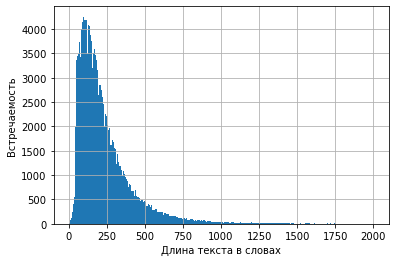

In [12]:
ax = df['word_count'].hist(bins='auto',range=[0, 2000])
ax.set_xlabel("–î–ª–∏–Ω–∞ —Ç–µ–∫—Å—Ç–∞ –≤ —Å–ª–æ–≤–∞—Ö")
ax.set_ylabel("–í—Å—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç—å")

Text(0, 0.5, '–í—Å—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç—å')

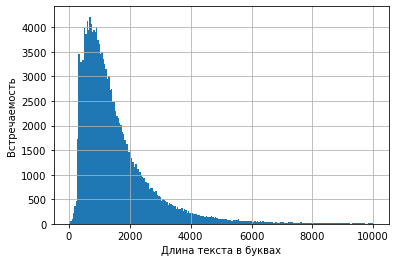

In [13]:
ax1 = df['char_count'].hist(bins='auto',range=[0, 10000])
ax1.set_xlabel("–î–ª–∏–Ω–∞ —Ç–µ–∫—Å—Ç–∞ –≤ –±—É–∫–≤–∞—Ö")
ax1.set_ylabel("–í—Å—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç—å")

3: –ù–∞–π–¥–∏—Ç–µ 10 —Å–∞–º—ã—Ö —á–∞—Å—Ç—ã—Ö:
—Å–ª–æ–≤
—Å–ª–æ–≤ –±–µ–∑ —Å—Ç–æ–ø-—Å–ª–æ–≤
–ª–µ–º–º
—Å—É—â–µ—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã—Ö

In [14]:
def words_only(text, regex=re.compile("[–ê-–Ø–∞-—è]+")):
    return " ".join(regex.findall(text))

mystopwords = stopwords.words('russian') + ['—ç—Ç–æ', '–Ω–∞—à' , '—Ç—ã—Å', '–º–ª–Ω', '–º–ª—Ä–¥', '—Ç–∞–∫–∂–µ',  '—Ç', '–¥']
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""


m = Mystem()
def lemmatize_(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


morph=MorphAnalyzer()
def noun_strip(text):
    try:
        return " ".join([item if morph.parse(item)[0].tag.POS=='NOUN' else " " for item in text.split()])
    except:
        return " "


def most_common(text):
    words_list = [word for text_ in text for word in text_.split()]
    cnt=Counter(words_list)
    return cnt.most_common(10)


def text_prep(text):
    text1 = words_only(text)
    text2 = remove_stopwords(text1)
    return lemmatize_(text2)

In [15]:
%%time
words1 = df.text.str.lower()
words1 = words1.apply(words_only)
words1

CPU times: user 14.3 s, sys: 484 ms, total: 14.8 s
Wall time: 15 s


0         –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è –Ω–µ —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –∏ –ø–æ—Ä—É...
1         –¥–æ–±—Ä–æ–≥–æ –¥–Ω—è —è–≤–ª—è—é—Å—å –¥–µ—Ä–∂–∞—Ç–µ–ª–µ–º –∑–∞—Ä–ø–ª–∞—Ç–Ω–æ–π –∫–∞—Ä—Ç...
2         –∑–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ –¥—É–±–ª–∏—Ä—É—é —Å–≤–æ–µ –∑–∞—è–≤–ª–µ–Ω–∏–µ –æ—Ç –≤ –¥–æ –º...
3         –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è –æ—Ç–∫—Ä—ã–ª —Ä–∞—Å—á–µ—Ç–Ω—ã–π —Å—á–µ—Ç –≤ —Å–±–µ—Ä–±–∞–Ω–∫...
4         –≥ –≤–∑—è–ª–∞ –∫—Ä–µ–¥–∏—Ç –≤ –≤–∞—à–µ–º –±–∞–Ω–∫–µ –∑–∞—è–≤–ª–µ–Ω–Ω–∞—è –º–Ω–æ—é —Å...
                                ...                        
153494    —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–æ–π –±–∞–Ω–∫ –Ω–µ –≤—Å–µ–≥–¥–∞ —É—á–∏—Ç—ã–≤–∞–µ—Ç –Ω–∞—à—É ...
153495    –≤—ã —Å–∞–º–∏ –≤–∏–Ω–æ–≤–∞—Ç—ã –≤ —Å–≤–æ–∏—Ö –ø—Ä–æ–±–ª–µ–º–∞—Ö –∫—Ä–æ–º–µ –ø—Ä–µ–¥–ø...
153496    —É–≤–∞–∂–∞–µ–º–æ–µ —Ä—É–∫–æ–≤–æ–¥—Å—Ç–≤–æ –±–∞–Ω–∫–∞ –æ–≤–∫ —è –ø—Ä–æ–∂–∏–≤–∞—é –≤ –≥...
153497    –ø—Ä–æ–±–æ–≤–∞–ª–∞ –æ—Ñ–æ—Ä–º–∏—Ç—å —Ç–æ–≤–∞—Ä –≤ –∫—Ä–µ–¥–∏—Ç –≤ –∞–ª—å—Ñ–∞ –±–∞–Ω–∫...
153498    –µ—Å–ª–∏ –∫–æ—Ä–æ—Ç–∫–æ —Ç–æ –º–Ω–µ –Ω—

In [16]:
%%time
words2 = words1.apply(remove_stopwords)
words2

CPU times: user 1min 11s, sys: 452 ms, total: 1min 12s
Wall time: 1min 13s


0         –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –ø–æ—Ä—É—á–∏—Ç–µ–ª–µ–º...
1         –¥–æ–±—Ä–æ–≥–æ –¥–Ω—è —è–≤–ª—è—é—Å—å –¥–µ—Ä–∂–∞—Ç–µ–ª–µ–º –∑–∞—Ä–ø–ª–∞—Ç–Ω–æ–π –∫–∞—Ä—Ç...
2         –∑–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ –¥—É–±–ª–∏—Ä—É—é —Å–≤–æ–µ –∑–∞—è–≤–ª–µ–Ω–∏–µ –º–æ–∂–∞–π—Å–∫–∏–π...
3         –¥–æ–±—Ä—ã–π –¥–µ–Ω—å –æ—Ç–∫—Ä—ã–ª —Ä–∞—Å—á–µ—Ç–Ω—ã–π —Å—á–µ—Ç —Å–±–µ—Ä–±–∞–Ω–∫–µ —é—Ä...
4         –≥ –≤–∑—è–ª–∞ –∫—Ä–µ–¥–∏—Ç –≤–∞—à–µ–º –±–∞–Ω–∫–µ –∑–∞—è–≤–ª–µ–Ω–Ω–∞—è –º–Ω–æ—é —Å—É–º...
                                ...                        
153494    —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–æ–π –±–∞–Ω–∫ —É—á–∏—Ç—ã–≤–∞–µ—Ç –Ω–∞—à—É —Å–ø–µ—Ü–∏—Ñ–∏–∫—É ...
153495    —Å–∞–º–∏ –≤–∏–Ω–æ–≤–∞—Ç—ã —Å–≤–æ–∏—Ö –ø—Ä–æ–±–ª–µ–º–∞—Ö –∫—Ä–æ–º–µ –ø—Ä–µ–¥–ø–æ—Å–ª–µ–¥...
153496    —É–≤–∞–∂–∞–µ–º–æ–µ —Ä—É–∫–æ–≤–æ–¥—Å—Ç–≤–æ –±–∞–Ω–∫–∞ –æ–≤–∫ –ø—Ä–æ–∂–∏–≤–∞—é –≥ –∏–≤–∞...
153497    –ø—Ä–æ–±–æ–≤–∞–ª–∞ –æ—Ñ–æ—Ä–º–∏—Ç—å —Ç–æ–≤–∞—Ä –∫—Ä–µ–¥–∏—Ç –∞–ª—å—Ñ–∞ –±–∞–Ω–∫–µ –∫–æ...
153498    –∫–æ—Ä–æ—Ç–∫–æ –Ω—Ä–∞–≤–∏—

In [17]:
%%time
words3 = words2.apply(lemmatize_)
words3

CPU times: user 1min 48s, sys: 6.78 s, total: 1min 55s
Wall time: 20min 15s


0         –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è–≤–ª—è—Ç—å—Å—è –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ –ø–æ—Ä—É—á–∏—Ç–µ–ª—å –∫—Ä...
1         –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è–≤–ª—è—Ç—å—Å—è –¥–µ—Ä–∂–∞—Ç–µ–ª—å –∑–∞—Ä–ø–ª–∞—Ç–Ω–æ–π –∫–∞—Ä—Ç...
2         –∑–¥—Ä–∞–≤—Å—Ç–≤–æ–≤–∞—Ç—å –¥—É–±–ª–∏—Ä–æ–≤–∞—Ç—å —Å–≤–æ–π –∑–∞—è–≤–ª–µ–Ω–∏–µ –º–æ–∂–∞–π...
3         –¥–æ–±—Ä—ã–π –¥–µ–Ω—å –æ—Ç–∫—Ä—ã–≤–∞—Ç—å —Ä–∞—Å—á–µ—Ç–Ω—ã–π —Å—á–µ—Ç —Å–±–µ—Ä–±–∞–Ω–∫ ...
4         –≥ –≤–∑—è—Ç—å –∫—Ä–µ–¥–∏—Ç –≤–∞—à –±–∞–Ω–∫ –∑–∞—è–≤–ª—è—Ç—å —è —Å—É–º–º–∞ —Ä—É–±–ª—å...
                                ...                        
153494    —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–æ–π –±–∞–Ω–∫ —É—á–∏—Ç—ã–≤–∞—Ç—å –Ω–∞—à —Å–ø–µ—Ü–∏—Ñ–∏–∫–∞ –ø...
153495    —Å–∞–º –≤–∏–Ω–æ–≤–∞—Ç—ã–π —Å–≤–æ–π –ø—Ä–æ–±–ª–µ–º–∞ –∫—Ä–æ–º–µ –ø—Ä–µ–¥–ø–æ—Å–ª–µ–¥–Ω–∏...
153496    —É–≤–∞–∂–∞—Ç—å —Ä—É–∫–æ–≤–æ–¥—Å—Ç–≤–æ –±–∞–Ω–∫ –æ–≤–∫ –ø—Ä–æ–∂–∏–≤–∞—Ç—å –≥ –∏–≤–∞–Ω–æ...
153497    –ø—Ä–æ–±–æ–≤–∞—Ç—å –æ—Ñ–æ—Ä–º–ª—è—Ç—å —Ç–æ–≤–∞—Ä –∫—Ä–µ–¥–∏—Ç –∞–ª—å—Ñ–∞ –±–∞–Ω–∫ –∫–æ...
153498    –∫–æ—Ä–æ—á–µ –Ω—Ä–∞–≤–∏—Ç—å—

In [18]:
%%time
words4 = words3.apply(noun_strip)
words4

CPU times: user 1h 13min 2s, sys: 6 s, total: 1h 13min 8s
Wall time: 1h 13min 26s


0           –¥–µ–Ω—å   –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ –ø–æ—Ä—É—á–∏—Ç–µ–ª—å   –¥–æ–≥–æ–≤–æ—Ä     ...
1           –¥–µ–Ω—å   –¥–µ—Ä–∂–∞—Ç–µ–ª—å   –∫–∞—Ä—Ç–∞   —Å–±–µ—Ä–±–∞–Ω–∫ —Ä–æ—Å—Å–∏—è –≥...
2               –∑–∞—è–≤–ª–µ–Ω–∏–µ         –∫–∞—Ä—Ç–∞   –ø–æ–∫—É–ø–∫–∞ –∏–Ω—Ç–µ—Ä–Ω...
3           –¥–µ–Ω—å     —Å—á–µ—Ç —Å–±–µ—Ä–±–∞–Ω–∫ —é—Ä –ª–∏—Ü–æ   –¥–æ–≥–æ–≤–æ—Ä   –∫...
4         –≥   –∫—Ä–µ–¥–∏—Ç   –±–∞–Ω–∫     —Å—É–º–º–∞ —Ä—É–±–ª—å –≥–æ–¥ –º–µ–Ω–µ–¥–∂–µ—Ä...
                                ...                        
153494        –±–∞–Ω–∫     —Å–ø–µ—Ü–∏—Ñ–∏–∫–∞ –ø—Ä–æ–¥—É–∫—Ç   –∫–∞—Ä—Ç–∞     –ø–æ–ª...
153495          –ø—Ä–æ–±–ª–µ–º–∞     —Å–æ–æ–±—â–µ–Ω–∏–µ   —Å—Ä—ã–≤ —Ä–µ—Å—Ç–æ—Ä–∞–Ω  ...
153496      —Ä—É–∫–æ–≤–æ–¥—Å—Ç–≤–æ –±–∞–Ω–∫     –≥ –∏–≤–∞–Ω–æ–≤–æ   —Ñ–∏–ª–∏–∞–ª   –±–∞...
153497        —Ç–æ–≤–∞—Ä –∫—Ä–µ–¥–∏—Ç –∞–ª—å—Ñ–∞ –±–∞–Ω–∫   —Ü–µ–Ω—Ç—Ä     –æ—Ñ–æ—Ä–º–ª...
153498              –¥–µ–ª–æ –∞–Ω–∫–µ—Ç–∞ –∏–Ω—Ç–µ—Ä–Ω–µ—Ç   –∑–≤–æ–Ω–æ–∫ —Å–∫—Ä–æ–∫–∏...
Name: text, Length: 153499, dtype: obj

In [19]:
most_common(words1)

[('–≤', 1330550),
 ('–∏', 1058997),
 ('–Ω–µ', 855335),
 ('–Ω–∞', 707935),
 ('—á—Ç–æ', 640057),
 ('—è', 577500),
 ('—Å', 464037),
 ('–ø–æ', 372769),
 ('–º–Ω–µ', 320958),
 ('–±–∞–Ω–∫–∞', 275906)]

In [20]:
most_common(words2)

[('–±–∞–Ω–∫–∞', 275906),
 ('–±–∞–Ω–∫', 215426),
 ('–¥–µ–Ω—å–≥–∏', 131201),
 ('–∫–∞—Ä—Ç—É', 105829),
 ('–∫–∞—Ä—Ç—ã', 101821),
 ('–∫—Ä–µ–¥–∏—Ç', 81136),
 ('–¥–µ–Ω—å', 76552),
 ('–±–∞–Ω–∫–µ', 72169),
 ('–∑–∞—è–≤–ª–µ–Ω–∏–µ', 70423),
 ('–æ—á–µ–Ω—å', 66824)]

In [21]:
most_common(words3)

[('–±–∞–Ω–∫', 623032),
 ('–∫–∞—Ä—Ç–∞', 334999),
 ('–¥–µ–Ω—å–≥–∏', 179734),
 ('–¥–µ–Ω—å', 173043),
 ('–º–æ–π', 163042),
 ('–∫—Ä–µ–¥–∏—Ç', 156177),
 ('–∫–æ—Ç–æ—Ä—ã–π', 148986),
 ('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 144050),
 ('–∫–ª–∏–µ–Ω—Ç', 136892),
 ('—Å–æ—Ç—Ä—É–¥–Ω–∏–∫', 134168)]

In [22]:
most_common(words4)

[('–±–∞–Ω–∫', 623032),
 ('–∫–∞—Ä—Ç–∞', 334999),
 ('–¥–µ–Ω—å–≥–∏', 179734),
 ('–¥–µ–Ω—å', 173043),
 ('–∫—Ä–µ–¥–∏—Ç', 156177),
 ('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 144050),
 ('–∫–ª–∏–µ–Ω—Ç', 136892),
 ('—Å–æ—Ç—Ä—É–¥–Ω–∏–∫', 134168),
 ('—Å—á–µ—Ç', 126894),
 ('—Å—É–º–º–∞', 111232)]

4: –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –∫—Ä–∏–≤—ã–µ –¶–∏–ø—Ñ–∞ –∏ –•–∏–ø—Å–∞

–ö—Ä–∏–≤–∞—è –¶–∏–ø—Ñ–∞ (–≤—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç—å —Å–ª–æ–≤–∞ –æ–±—Ä–∞—Ç–Ω–æ –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–∞ –µ–≥–æ –ø–æ—Ä—è–¥–∫—É)

Text(0, 0.5, '–í—Å—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç—å')

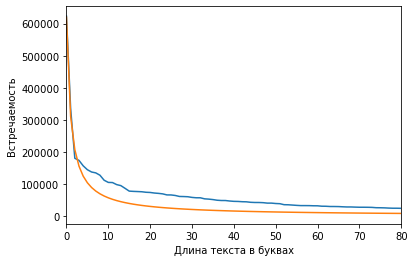

In [25]:
words_ = [word for text_ in words4 for word in text_.split()]
cnt=Counter(words_)
plt.plot(sort(list(cnt.values()))[::-1][:100])
plt.plot([620000/x for x in range(1,101)])
plt.xlim([0,80])
plt.xlabel("–î–ª–∏–Ω–∞ —Ç–µ–∫—Å—Ç–∞ –≤ –±—É–∫–≤–∞—Ö")
plt.ylabel("–í—Å—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç—å")

–ö—Ä–∏–≤–∞—è –•–∏–ø—Å–∞ (–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–∞–∑–Ω—ã—Ö —Å–ª–æ–≤ –≤ —Ç–µ–∫—Å—Ç–µ –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–æ –µ–≥–æ –¥–ª–∏–Ω–µ)

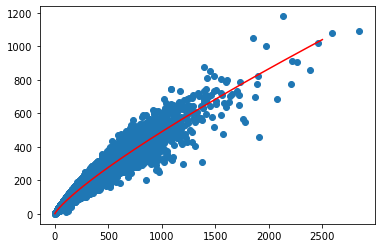

In [26]:
plt.scatter(x=[len(text.split()) for text in words3], y=[len(Counter(text.split())) for text in words3])
plt.plot([1.7*x**0.82 for x in range(1,2502)], c='r')

5: –û—Ç–≤–µ—Ç—å—Ç–µ –Ω–∞ —Å–ª–µ–¥—É—é—â–∏–µ –≤–æ–ø—Ä–æ—Å—ã:
- –∫–∞–∫–æ–µ —Å–ª–æ–≤–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ, "—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" –∏–ª–∏ "–∫–ª–∏–µ–Ω—Ç"?
- —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —Å–ª–æ–≤–∞ "–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ" –∏ "–¥–æ–≤–µ—Ä–∏–µ"?

In [27]:
most_common(words4)

[('–±–∞–Ω–∫', 623032),
 ('–∫–∞—Ä—Ç–∞', 334999),
 ('–¥–µ–Ω—å–≥–∏', 179734),
 ('–¥–µ–Ω—å', 173043),
 ('–∫—Ä–µ–¥–∏—Ç', 156177),
 ('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 144050),
 ('–∫–ª–∏–µ–Ω—Ç', 136892),
 ('—Å–æ—Ç—Ä—É–¥–Ω–∏–∫', 134168),
 ('—Å—á–µ—Ç', 126894),
 ('—Å—É–º–º–∞', 111232)]

'–ö–ª–∏–µ–Ω—Ç' –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ.

In [28]:
cnt=Counter([word for text_ in words4 for word in text_.split()])
print('–ú–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ:',cnt.get('–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ'))
print('–î–æ–≤–µ—Ä–∏–µ:',cnt.get('–¥–æ–≤–µ—Ä–∏–µ'))

–ú–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ: 3244
–î–æ–≤–µ—Ä–∏–µ: 2108


–í –ø–æ–ª–µ "rating_grade" –∑–∞–ø–∏—Å–∞–Ω–∞ –æ—Ü–µ–Ω–∫–∞ –æ—Ç–∑—ã–≤–∞ –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –º–µ—Ä—É  ùë°ùëì‚àíùëñùëëùëì , –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –Ω–∞–π—Ç–∏ –∫–ª—é—á–µ–≤—ã–µ —Å–ª–æ–≤–∞ –∏ –±–∏–≥—Ä–∞–º—ã –¥–ª—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 5) –∏ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 1)

In [29]:
pos=df[df.rating_grade==5]
neg=df[df.rating_grade==1]

In [30]:
%%time
pos3 = pos.text.apply(text_prep)

CPU times: user 18 s, sys: 621 ms, total: 18.6 s
Wall time: 2min 4s


In [31]:
%%time
neg3 = neg.text.apply(text_prep)

CPU times: user 1min 14s, sys: 2.27 s, total: 1min 17s
Wall time: 8min 20s


In [32]:
tfidf_pos = TfidfVectorizer(max_df=0.85,max_features=10000,ngram_range=(1,2))
tfidf_pos_m = tfidf_pos.fit_transform(list(pos3))
list(tfidf_pos.vocabulary_.keys())[:50]

['–¥–æ—Å—Ä–æ—á–Ω–æ',
 '–∑–∞–∫—Ä—ã–≤–∞—Ç—å',
 '–≤–∫–ª–∞–¥',
 '–æ—Ç–ø—É—Å–∫',
 '–∂–µ–Ω–∞',
 '–∑–∞–∫–∞–∑—ã–≤–∞—Ç—å',
 '–∑–∞—Ä–∞–Ω–µ–µ',
 '–∑–∞–±—ã–≤–∞—Ç—å',
 '—Å–æ—Ç—Ä—É–¥–Ω–∏–∫',
 '—Å–ø–±',
 '–Ω–∞—Ç–∞–ª—å—è',
 '–æ—Ç–∫–∞–∑—ã–≤–∞—Ç—å',
 '—Ö–æ—Ç—è',
 '—Å—É–º–º–∞',
 '–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–π',
 '—Ä–∞–±–æ—Ç–∞—Ç—å',
 '–±—ã—Å—Ç—Ä–æ',
 '–ø—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω–æ',
 '–Ω–∏—á—Ç–æ',
 '–ª–∏—à–Ω–∏–π',
 '–∂–∞–ª—å',
 '–ø—Ä–∏–µ–º',
 '–æ—Ñ–∏—Å',
 '–¥–æ—Å—Ç—É–ø–Ω–æ—Å—Ç—å',
 '–∑–∞–º–µ—á–∞—Ç—å',
 '–Ω–µ—Å—Ç–∏',
 '–¥–µ–Ω—å–≥–∏',
 '–±—Ä–∞—Ç—å',
 '–∫—Ä–µ–¥–∏—Ç',
 '–∂–µ–ª–∞—Ç—å',
 '—É—Å–ø–µ—Ö',
 '–±–∞–Ω–∫–∞',
 '–¥–æ—Å—Ä–æ—á–Ω–æ –∑–∞–∫—Ä—ã–≤–∞—Ç—å',
 '–∑–∞–∫—Ä—ã–≤–∞—Ç—å –≤–∫–ª–∞–¥',
 '–∑–∞–∫–∞–∑—ã–≤–∞—Ç—å –∑–∞—Ä–∞–Ω–µ–µ',
 '—Å–æ—Ç—Ä—É–¥–Ω–∏–∫ –±–∞–Ω–∫',
 '—Ä–∞–±–æ—Ç–∞—Ç—å –±—ã—Å—Ç—Ä–æ',
 '–±—ã—Å—Ç—Ä–æ –ø—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω–æ',
 '–≤–∫–ª–∞–¥ –æ—Ñ–∏—Å',
 '–¥–µ–Ω—å–≥–∏ –≤–∫–ª–∞–¥',
 '–±—Ä–∞—Ç—å –∫—Ä–µ–¥–∏—Ç',
 '–∂–µ–ª–∞—Ç—å —É—Å–ø–µ—Ö',
 '—Ö–æ—Ç–µ—Ç—å',
 '–æ—Ç–∫—Ä—ã–≤–∞—Ç—å',
 '–¥–æ—Ö–æ–¥–Ω—ã–π',
 '–≥–æ–¥'

In [33]:
tfidf_neg = TfidfVectorizer(max_df=0.85,max_features=10000,ngram_range=(1,2))
tfidf_neg_m = tfidf_neg.fit_transform(list(neg3))
list(tfidf_neg.vocabulary_.keys())[:50]

['–æ—Ç–∫—Ä—ã–≤–∞—Ç—å',
 '–≤–∫–ª–∞–¥',
 '—Å—á–µ—Ç',
 '–ø–ª—é—Å',
 '—ç—Ç–æ—Ç',
 '–∑–∞—Ä–ø–ª–∞—Ç–Ω—ã–π',
 '–∫–∞—Ä—Ç–∞',
 '—Ä—É–±–ª—å',
 '—Å–∞–º',
 '—Å–µ–±—è',
 '—Å–µ–≥–æ–¥–Ω—è',
 '–ø—Ä–∏—Ö–æ–¥–∏—Ç—å',
 '—É–∫–∞–∑–∞–Ω–Ω—ã–π',
 '–æ—Ç–¥–µ–ª–µ–Ω–∏–µ',
 '—Ü–µ–ª—å',
 '–ø–æ–ø–æ–ª–Ω—è—Ç—å',
 '–¥–æ–ª–ª–∞—Ä–æ–≤—ã–π',
 '—Å—á',
 '–¥–∞–≤–∞—Ç—å',
 '–æ–ø–µ—Ä–∞—Ü–∏–æ–Ω–∏—Å—Ç',
 '–ø–∞—Å–ø–æ—Ä—Ç',
 '–æ–∫–æ—à–∫–æ',
 '–Ω–∞–ø–∏—Å–∞—Ç—å',
 '–ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω–∏–µ',
 '–æ–ø–µ—Ä–∞—Ü–∏—è',
 '–ø–æ–¥–æ–±–Ω—ã–π',
 '–ø—Ä–æ—à–ª—ã–π',
 '–ø–æ—Ç—Ä–µ–±–æ–≤–∞—Ç—å',
 '—Å–∫–∞–∑–∞—Ç—å',
 '–Ω—É–∂–Ω–æ',
 '–ø–æ–ª–∞–≥–∞—Ç—å',
 '–¥–µ–Ω—å–≥–∏',
 '–≤—Å',
 '–≤–∑—è—Ç—å',
 '–¥–µ–ª–∞—Ç—å',
 '–∫—Ä—É—Ç–∏—Ç—å',
 '–≤—Å—Ç–∞–≤–ª—è—Ç—å',
 '—Ç–µ—Ä–º–∏–Ω–∞–ª',
 '–≤–≤–æ–¥–∏—Ç—å',
 '–ø–∏–Ω',
 '–ø–æ–ª—É—á–∞—Ç—å',
 '–æ—Ç–≤–µ—Ç',
 '—á–µ–∫',
 '–¥–æ–ª–ª–∞—Ä',
 '–≤–Ω–æ—Å–∏—Ç—å',
 '–≤–æ–ø—Ä–æ—Å',
 '–±–∞–Ω–∫–∞',
 '–ø–æ–Ω–∏–º–∞—Ç—å',
 '–∫—Ç–æ',
 '—Å–æ–∑–Ω–∞—Ç–µ–ª—å–Ω–æ']

## –ß–∞—Å—Ç—å 2. –¢–µ–º–∞—Ç–∏—á–µ—Å–∫–æ–µ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–µ [20/100]

1. –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏—Ö –º–æ–¥–µ–ª–µ–π –∫–æ–ª–ª–µ–∫—Ü–∏–∏ –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ —Å —Ä–∞–∑–Ω—ã–º —á–∏—Å–ª–æ–º —Ç–µ–º. –ü—Ä–∏–≤–µ–¥–∏—Ç–µ –ø—Ä–∏–º–µ—Ä—ã –ø–æ–Ω—è—Ç–Ω—ã—Ö (–∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∏—Ä—É–µ–º—ã—Ö) —Ç–µ–º.
2. –ù–∞–π–¥–∏—Ç–µ —Ç–µ–º—ã, –≤ –∫–æ—Ç–æ—Ä—ã—Ö —É–ø–æ–º—è–Ω—É—Ç—ã –∫–æ–Ω–∫—Ä–µ—Ç–Ω—ã–µ –±–∞–Ω–∫–∏ (–°–±–µ—Ä–±–∞–Ω–∫, –í–¢–ë, –¥—Ä—É–≥–æ–π –±–∞–Ω–∫). –ú–æ–∂–µ—Ç–µ –ª–∏ –≤—ã –∏—Ö –ø—Ä–æ–∫–æ–º–º–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å / –æ–±—ä—è—Å–Ω–∏—Ç—å?

–≠—Ç–∞ —á–∞—Å—Ç—å –∑–∞–¥–∞–Ω–∏—è –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–¥–µ–ª–∞–Ω–∞ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º gensim. 

In [48]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel, lsimodel
from gensim import similarities
import pyLDAvis
from pyLDAvis import gensim_models

In [49]:
texts = [text.split() for text in words4]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [50]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

–ü–æ–ø—Ä–æ–±—É–µ–º –ø–æ 5 —Ç–µ–º —Å LSI, LDA.

In [51]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
lda = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

CPU times: user 2min 46s, sys: 3.9 s, total: 2min 50s
Wall time: 2min 29s


In [52]:
lsi.show_topics()

[(0,
  '0.273*"–∫–∞—Ä—Ç–∞" + 0.178*"–∫—Ä–µ–¥–∏—Ç" + 0.159*"–¥–µ–Ω—å–≥–∏" + 0.148*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.148*"—Å—á–µ—Ç" + 0.141*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.140*"–≤–∫–ª–∞–¥" + 0.137*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.133*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.131*"—Å—É–º–º–∞"'),
 (1,
  '-0.793*"–≤–∫–ª–∞–¥" + -0.155*"–æ—á–µ—Ä–µ–¥—å" + 0.139*"–∫—Ä–µ–¥–∏—Ç" + 0.115*"–∫–∞—Ä—Ç–∞" + 0.114*"–ø–ª–∞—Ç–µ–∂" + -0.110*"–ø—Ä–æ—Ü–µ–Ω—Ç" + 0.108*"—Å–±–µ—Ä–±–∞–Ω–∫" + -0.105*"–æ—Ñ–∏—Å" + -0.099*"–≤–∫–ª–∞–¥—á–∏–∫" + 0.097*"–∑–∞—è–≤–ª–µ–Ω–∏–µ"'),
 (2,
  '-0.464*"–∫—Ä–µ–¥–∏—Ç" + 0.355*"–∫–∞—Ä—Ç–∞" + 0.301*"–±–∞–Ω–∫–æ–º–∞—Ç" + -0.253*"—Å—Ç—Ä–∞—Ö–æ–≤–∫–∞" + 0.195*"—Å–±–µ—Ä–±–∞–Ω–∫" + -0.189*"–¥–æ–≥–æ–≤–æ—Ä" + -0.152*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + 0.147*"–æ–ø–µ—Ä–∞—Ü–∏—è" + -0.141*"–ø–ª–∞—Ç–µ–∂" + 0.140*"–¥–µ–Ω—å–≥–∏"'),
 (3,
  '0.277*"–∑–∞—è–≤–∫–∞" + 0.255*"–Ω–æ–º–µ—Ä" + -0.242*"—Å—É–º–º–∞" + -0.236*"–ø–ª–∞—Ç–µ–∂" + -0.219*"—Ä—É–±" + 0.213*"–∑–≤–æ–Ω–æ–∫" + -0.170*"—Ä—É–±–ª—å" + -0.166*"—Å—á–µ—Ç" + -0.162*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.160*"—Ç–µ–ª–µ—Ñ–æ–

–°–∫–æ—Ä–µ –≤—Å–µ–≥–æ, –ø–µ—Ä–≤–∞—è —Ç–µ–º–∞ —Å–≤—è–∑–∞–Ω–∞ —Å –≤—Å–µ–≤–æ–∑–º–æ–∂–Ω—ã–º–∏ –æ–ø—Ü–∏—è–º–∏ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è —Å –±–∞–Ω–∫–æ–º: –æ—Ç–∫—Ä—ã—Ç–∏–µ –≤–∫–ª–∞–¥–æ–≤, —Å—á–µ—Ç–æ–≤, –ø–æ–ª—É—á–µ–Ω–∏–µ –∫—Ä–µ–¥–∏—Ç–æ–≤.
–ß–µ—Ç–≤–µ—Ä—Ç–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è —Å–≤—è–∑–∞–Ω–∞ —Å —Ç–µ–ª–µ—Ñ–æ–Ω–Ω—ã–º–∏ –æ–ø–µ—Ä–∞—Ü–∏—è–º–∏.

In [53]:
lda.show_topics()

[(0,
  '0.012*"–∫–∞—Ä—Ç–∞" + 0.009*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.007*"–¥–µ–Ω—å–≥–∏" + 0.007*"—Å—á–µ—Ç" + 0.006*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.005*"–∫–∞—Ä—Ç–æ—á–∫–∞" + 0.005*"–æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ" + 0.005*"–∫–ª–∏–µ–Ω—Ç" + 0.005*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.004*"–¥–µ–Ω—å"'),
 (1,
  '0.013*"–∫—Ä–µ–¥–∏—Ç" + 0.010*"–¥–æ–∫—É–º–µ–Ω—Ç" + 0.007*"–æ—á–µ—Ä–µ–¥—å" + 0.006*"–º–µ–Ω–µ–¥–∂–µ—Ä" + 0.006*"–∑–∞—è–≤–∫–∞" + 0.005*"–¥–µ–≤—É—à–∫–∞" + 0.005*"–∞–Ω–∫–µ—Ç–∞" + 0.005*"—á–µ–ª–æ–≤–µ–∫" + 0.005*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.005*"–æ—Ñ–∏—Å"'),
 (2,
  '0.044*"–≤–∫–ª–∞–¥" + 0.011*"–¥–µ–ø–æ–∑–∏—Ç" + 0.010*"–æ—á–µ—Ä–µ–¥—å" + 0.010*"–æ–ø–µ—Ä–∞—Ü–∏–æ–Ω–∏—Å—Ç–∫–∞" + 0.008*"–≤–∫–ª–∞–¥—á–∏–∫" + 0.007*"–∫–∞—Å—Å–∞" + 0.007*"–ø–æ–¥–∞—Ä–æ–∫" + 0.007*"—Å—Ç–∞–≤–∫–∞" + 0.007*"—è—á–µ–π–∫–∞" + 0.006*"–ø—Ä–æ—Ü–µ–Ω—Ç"'),
 (3,
  '0.020*"–∫—Ä–µ–¥–∏—Ç" + 0.014*"–ø–ª–∞—Ç–µ–∂" + 0.013*"–∑–∞–¥–æ–ª–∂–µ–Ω–Ω–æ—Å—Ç—å" + 0.012*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + 0.011*"–¥–æ–≥–æ–≤–æ—Ä" + 0.011*"—Å—É–º–º–∞" + 0.010*"—à—Ç—Ä–∞—Ñ" + 0.008*"–º–µ—Å—è—Ü" + 0.008*"–¥–æ–ª

–ü–µ—Ä–≤–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è —Å–≤—è–∑–∞–Ω–∞, —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ —Å –º–æ—à–µ–Ω–Ω–∏—á–µ—Å–∫–∏–º–∏ —Ç–µ–º–∞–º–∏.
–í—Ç–æ—Ä–∞—è - —Å –æ–ø—ã—Ç–æ–º –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è —Å –æ—Ç–¥–µ–ª–µ–Ω–∏—è–º–∏ –±–∞–Ω–∫–æ–≤.
–¢—Ä–µ—Ç—å—è - —Å –∫—Ä–µ–¥–∏—Ç–∞–º–∏.

In [54]:
%%time
lsi10 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)
lda10 = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: user 2min 49s, sys: 3.85 s, total: 2min 53s
Wall time: 2min 31s


In [55]:
lsi10.show_topics()

[(0,
  '0.273*"–∫–∞—Ä—Ç–∞" + 0.178*"–∫—Ä–µ–¥–∏—Ç" + 0.160*"–¥–µ–Ω—å–≥–∏" + 0.148*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.148*"—Å—á–µ—Ç" + 0.143*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.140*"–≤–∫–ª–∞–¥" + 0.137*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.132*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.131*"—Å—É–º–º–∞"'),
 (1,
  '-0.793*"–≤–∫–ª–∞–¥" + -0.144*"–æ—á–µ—Ä–µ–¥—å" + 0.136*"–∫–∞—Ä—Ç–∞" + 0.132*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.116*"—Å–±–µ—Ä–±–∞–Ω–∫" + -0.115*"–ø—Ä–æ—Ü–µ–Ω—Ç" + 0.111*"–ø–ª–∞—Ç–µ–∂" + -0.103*"–æ—Ñ–∏—Å" + -0.101*"—Å—Ç–∞–≤–∫–∞" + -0.100*"–≤–∫–ª–∞–¥—á–∏–∫"'),
 (2,
  '-0.462*"–∫—Ä–µ–¥–∏—Ç" + 0.362*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.310*"–∫–∞—Ä—Ç–∞" + -0.221*"—Å—Ç—Ä–∞—Ö–æ–≤–∫–∞" + -0.179*"–¥–æ–≥–æ–≤–æ—Ä" + 0.175*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.161*"–¥–µ–Ω—å–≥–∏" + -0.156*"–ø–ª–∞—Ç–µ–∂" + -0.153*"–ø–æ–≥–∞—à–µ–Ω–∏–µ" + 0.148*"–æ–ø–µ—Ä–∞—Ü–∏—è"'),
 (3,
  '-0.347*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.288*"–∑–∞—è–≤–∫–∞" + 0.266*"–∫–∞—Ä—Ç–∞" + -0.234*"—Å—É–º–º–∞" + -0.204*"–ø–ª–∞—Ç–µ–∂" + -0.195*"—Ä—É–±" + 0.176*"–Ω–æ–º–µ—Ä" + -0.173*"–¥–µ–Ω—å–≥–∏" + -0.158*"—Ä—É–±–ª—å" + -0.152*"–ø–æ–≥–∞—à–

–ó–∞—á–∞—Å—Ç—É—é –≤ —Ç–µ–º–∞—Ö –æ–¥–Ω–æ–≤—Ä–µ–º–µ–Ω–Ω–æ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç –≤–º–µ—Å—Ç–µ —Å —É –ø–æ–Ω–º–∏–Ω–∞–Ω–∏–µ–º —Å–±–µ—Ä–±–∞–Ω–∫–∞ —Å–ª–æ–≤–∞: –±–∞–Ω–∫–æ–º–∞—Ç, –∫–∞—Ä—Ç–∞, —Å—Ç—Ä–∞—Ö–æ–≤–∫–∞, –≤–∫–ª–∞–¥. –í–æ–∑–º–æ–∂–Ω–æ, —ç—Ç–æ –±—ã–ª–∏ –æ—Å–Ω–æ–≤–Ω—ã–µ –ø—Ä–æ–±–ª–µ–º–Ω—ã–µ –º–µ—Å—Ç–∞ –≤ –æ—Ç–∑—ã–≤–∞—Ö.

In [56]:
lda10.show_topics()

[(0,
  '0.018*"–±–∞–Ω–∫–æ–º–∞—Ç" + 0.012*"–¥–µ–Ω—å–≥–∏" + 0.012*"–∫–∞—Ä—Ç–∞" + 0.011*"—Å—á–µ—Ç" + 0.010*"–ø–ª–∞—Ç–µ–∂" + 0.009*"—Å—É–º–º–∞" + 0.009*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.008*"–ø—Ä–µ—Ç–µ–Ω–∑–∏—è" + 0.008*"–∫—Ä–µ–¥–∏—Ç" + 0.008*"—Ä—É–±–ª—å"'),
 (1,
  '0.017*"–ø–∞–π" + 0.014*"–º–∏–ª–∏—Ü–∏—è" + 0.011*"–º–∏–Ω–∏" + 0.010*"–º–æ—Å–∫–æ–º–ø—Ä–∏–≤–∞—Ç–±–∞–Ω–∫" + 0.009*"—Å—Ç–µ–∫–ª–æ" + 0.009*"–∫—Ä–∏—Ç–µ—Ä–∏–π" + 0.009*"–±–∞–Ω–∫–Ω–æ—Ç–∞" + 0.008*"–∂—É—Ä–Ω–∞–ª" + 0.007*"–∑–∞–º–∏–Ω–∫–∞" + 0.007*"–≥—Ä–∞—Ñ"'),
 (2,
  '0.025*"–∫—Ä–µ–¥–∏—Ç" + 0.019*"–¥–æ–∫—É–º–µ–Ω—Ç" + 0.015*"–∑–∞—è–≤–∫–∞" + 0.013*"—Å–∏—Ç–∏—Ñ–æ–Ω" + 0.012*"—Å–¥–µ–ª–∫–∞" + 0.010*"–∫–≤–∞—Ä—Ç–∏—Ä–∞" + 0.010*"—Å—Ç—Ä–∞—Ö–æ–≤–∫–∞" + 0.010*"–º–µ–Ω–µ–¥–∂–µ—Ä" + 0.009*"–∞–≤—Ç–æ–∫—Ä–µ–¥–∏—Ç" + 0.009*"–∞–≤—Ç–æ—Å–∞–ª–æ–Ω"'),
 (3,
  '0.021*"–∫–æ–º–∏—Ç–µ—Ç" + 0.015*"—Å—Ç–µ–Ω–¥" + 0.014*"–≥—Ä—É–±–æ—Å—Ç—å" + 0.011*"–∫–∞–±–∏–Ω–∫–∞" + 0.010*"–∑–∞—Å—Ç—Ä–æ–π—â–∏–∫" + 0.010*"–ª–µ–Ω—Ç–∞" + 0.009*"–¥–æ–ª–ª" + 0.009*"—Å–ø–µ–∫—Ç—Ä" + 0.009*"–Ω–µ–¥–æ—á–µ—Ç" + 

In [57]:
pyLDAvis.enable_notebook()

In [58]:
vis = gensim_models.prepare(lda10, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.306158  0.023141       1        1  27.470136
0     -0.264696  0.008867       2        1  22.400483
6     -0.232347 -0.035373       3        1  16.937511
7     -0.264042  0.046207       4        1  14.653855
2     -0.167914 -0.052239       5        1   6.441605
8      0.240777 -0.228519       6        1   2.535761
1      0.232974  0.043086       7        1   2.505750
4      0.250691  0.027227       8        1   2.431792
5      0.255475  0.093163       9        1   2.324642
3      0.255240  0.074439      10        1   2.298465, topic_info=              Term         Freq        Total Category  logprob  loglift
25          –∫—Ä–µ–¥–∏—Ç  5682.000000  5682.000000  Default  30.0000  30.0000
337          –≤–∫–ª–∞–¥  3567.000000  3567.000000  Default  29.0000  29.0000
13        –¥–æ–∫—É–º–µ–Ω—Ç  2910.000000  2910.000000  Default  28.0000  28.0000
296       –±–∞–Ω–∫–æ–º–∞—Ç  4796.000000  4796.000000  Default  27.0000  27.0000
222         –∑–∞—è–≤–∫–∞  2313.000000  2313.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1292    –∑–∞—Å—Ç—Ä–æ–π—â–∏–∫   179.481185   196.250022  Topic10  -4.5990   3.6836
1684  –Ω–æ–≤–æ–≤–≤–µ–¥–µ–Ω–∏–µ   109.962404   117.947973  Topic10  -5.0889   3.7028
1980          –¥–æ–ª–ª   166.702501   246.403129  Topic10  -4.6729   3.3822
2127        –≤—Ç–æ—Ä–æ–µ    88.144870   105.917155  Topic10  -5.3101   3.5893
1939           —Ö–∞–º   121.497827   177.264251  Topic10  -4.9892   3.3952

[613 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3019      4  0.989573       –∞–±–∞
5231      9  0.997584   –∞–±—Å–æ–ª—é—Ç
939       1  0.902418  –∞–≤–∞–Ω–≥–∞—Ä–¥
939       2  0.055705  –∞–≤–∞–Ω–≥–∞—Ä–¥
939       4  0.040850  –∞–≤–∞–Ω–≥–∞—Ä–¥
...     ...       ...       ...
6062      5  0.004161    —é—Ä–ª–∏—Ü–∞
6062      6  0.994529    —é—Ä–ª–∏—Ü–∞
1114      2  0.055285    —è—á–µ–π–∫–∞
1114      6  0.916816    —è—á–µ–π–∫–∞
1114      7  0.027643    —è—á–µ–π–∫–∞

[1238 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 7, 8, 3, 9, 2, 5, 6, 4])

## –ß–∞—Å—Ç—å 3. –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–æ–≤ [40/100]

–°—Ñ–æ—Ä–º—É–ª–∏—Ä—É–µ–º –¥–ª—è –ø—Ä–æ—Å—Ç–æ—Ç—ã –∑–∞–¥–∞—á—É –±–∏–Ω–∞—Ä–Ω–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏: –±—É–¥–µ–º –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –Ω–∞ –¥–≤–∞ –∫–ª–∞—Å—Å–∞, —Ç–æ –µ—Å—Ç—å, —Ä–∞–∑–ª–∏—á–∞—Ç—å —Ä–µ–∑–∫–æ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –æ—Ç–∑—ã–≤—ã (—Å –æ—Ü–µ–Ω–∫–æ–π 1) –∏ –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–µ –æ—Ç–∑—ã–≤—ã (—Å –æ—Ü–µ–Ω–∫–æ–π 5). 

1.  –°–æ—Å—Ç–∞–≤—å—Ç–µ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ –º–Ω–æ–∂–µ—Å—Ç–≤–æ: –≤—ã–±–µ—Ä–∏—Ç–µ –∏–∑ –≤—Å–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö N1 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 1 –∏ N2 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 5 (–∑–Ω–∞—á–µ–Ω–∏–µ N1 –∏ N2 ‚Äì –Ω–∞ –≤–∞—à–µ —É—Å–º–æ—Ç—Ä–µ–Ω–∏–µ). –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ ```sklearn.model_selection.train_test_split``` –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –º–Ω–æ–∂–µ—Å—Ç–≤–∞ –æ—Ç–æ–±—Ä–∞–Ω–Ω—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –Ω–∞ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ. 
2. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –ª—é–±–æ–π –∏–∑–≤–µ—Å—Ç–Ω—ã–π –≤–∞–º –∞–ª–≥–æ—Ä–∏—Ç–º –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–æ–≤ –¥–ª—è —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –∏ –ø–æ–ª—É—á–∏—Ç–µ baseline. –°—Ä–∞–≤–Ω–∏—Ç–µ —Ä–∞–∑–Ω—ã–µ –≤–∞—Ä–∏–∞–Ω—Ç—ã –≤–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–∞: –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Ç–æ–ª—å–∫–æ —É–Ω–∏–≥—Ä–∞–º, –ø–∞—Ä –∏–ª–∏ —Ç—Ä–æ–µ–∫ —Å–ª–æ–≤ –∏–ª–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Å–∏–º–≤–æ–ª—å–Ω—ã—Ö $n$-–≥—Ä–∞–º. 
3. –°—Ä–∞–≤–Ω–∏—Ç–µ, –∫–∞–∫ –∏–∑–º–µ–Ω—è–µ—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –ø—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ —Å–∫—Ä—ã—Ç—ã—Ö —Ç–µ–º –≤ –∫–∞—á–µ—Å—Ç–≤–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
* 1-—ã–π –≤–∞—Ä–∏–∞–Ω—Ç: $tf-idf$ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ (```sklearn.feature_extraction.text.TfidfTransformer```) –∏ —Å–∏–Ω–≥—É–ª—è—Ä–Ω–æ–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–µ (–æ–Ω–æ –∂–µ ‚Äì –ª–∞—Ç–µ–Ω—Ç—ã–π —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑) (```sklearn.decomposition.TruncatedSVD```), 
* 2-–æ–π –≤–∞—Ä–∏–∞–Ω—Ç: —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –º–æ–¥–µ–ª–∏ LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

–ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ accuracy –∏ F-measure –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏. 

–ù–∏–∂–µ –Ω–∞–ø–∏—Å–∞–Ω –ø—Ä–∏–º–µ—Ä–Ω—ã–π Pipeline –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–æ–≤. 

–≠—Ç–∞ —á–∞—Å—Ç—å –∑–∞–¥–∞–Ω–∏—è –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–¥–µ–ª–∞–Ω–∞ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º sklearn. 

In [ ]:


# !!! –ù–∞ –∫–∞–∂–¥–æ–º —ç—Ç–∞–ø–µ Pipeline –Ω—É–∂–Ω–æ —É–∫–∞–∑–∞—Ç—å —Å–≤–æ–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
# 1-—ã–π –≤–∞—Ä–∏–∞–Ω—Ç: tf-idf + LSI
# 2-–æ–π –≤–∞—Ä–∏–∞–Ω—Ç: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [63]:
pos_ = pos.sample(frac=0.5)
neg_ = neg.sample(frac=0.5)

In [67]:
df_ = pd.concat([pos_,neg_]).sample(frac=1).reset_index(drop=True)
df_.head()

city  rating_not_checked  \
0           –≥. –ú–æ—Å–∫–≤–∞               False   
1     –≥. –ü–µ—Ç—Ä–æ–∑–∞–≤–æ–¥—Å–∫               False   
2  –≥. –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥               False   
3                None               False   
4           –≥. –¢—é–º–µ–Ω—å               False   

                                      title  num_comments     bank_license  \
0                      –û–±–∏–¥–Ω–æ –∏ —É–Ω–∏–∑–∏—Ç–µ–ª—å–Ω–æ             1  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 3128   
1       –î–≤–∞–∂–¥—ã —Å–ø–∏—Å–∞–ª–∏ –≥–æ–¥–æ–≤–æ–µ –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ             7  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2289   
2  –ë–∞–Ω–∫–æ–º–∞—Ç –í–¢–ë –Ω–µ –∑–∞—á–∏—Å–ª–∏–ª –¥–µ–Ω—å–≥–∏ –Ω–∞ –∫–∞—Ä—Ç—É             2  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1623   
3       –î–µ–Ω–µ–≥ –Ω–µ –≤—ã–¥–∞–ª–∏, –∞ —Å–æ —Å—á–µ—Ç–∞ —Å–ø–∏—Å–∞–ª–∏             2  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1637   
4           –ú–æ–±–∏–ª—å–Ω—ã–π –±–∞–Ω–∫ - –∫–∞–∫ –∏ –°–±–µ—Ä–±–∞–Ω–∫            24  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481   

      author         bank_name             datetime  \
0      –≤–µ—Ç–∫–∞          –ë–∞–Ω–∫ –ò–¢–ë  2012-03-01 23:37:00   
1    Zefir31  –†—É—Å—Å–∫–∏–π –°—Ç–∞–Ω–¥–∞—Ä—Ç  2014-09-14 21:03:00   
2   maria222            –í–¢–ë 24  2013-11-07 02:38:00   
3  alfastroi          –°–î–ú-–ë–∞–Ω–∫  2008-08-19 18:12:00   
4    foxskum   –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2012-05-16 09:06:00   

                                                text  rating_grade  \
0  –°–µ–≥–æ–¥–Ω—è, 1 –º–∞—Ä—Ç–∞ 2012–≥ —è –ø—Ä–∏—à–ª–∞ –≤ –æ—Ñ–∏—Å –ò–¢–ë –ë–∞–Ω...           1.0   
1  –î–æ–±—Ä—ã–π –≤–µ—á–µ—Ä! –Ø –ø—Ä–æ—à—É –≤–∞—Å –ø–æ–º–æ—á—å! –ë–ª–∞–≥–æ–¥–∞—Ä—è —Å–≤...           1.0   
2  6 –Ω–æ—è–±—Ä—è 2013 –≥–æ–¥–∞ —è –≤–Ω–æ—Å–∏–ª–∞ –¥–µ–Ω—å–≥–∏ –Ω–∞ –∫–∞—Ä—Ç—É –≤...           1.0   
3  –°–µ–≥–æ–¥–Ω—è –≤ –±–∞–Ω–∫–æ–º–∞—Ç–µ –±–∞–Ω–∫–∞ –Ω–∞ 65 –∫–º –ú–ö–ê–î –ø–æ –∫–∞—Ä...           1.0   
4  –ï—Å—Ç—å –∫–∞—Ä—Ç–æ—á–∫–∞, –æ—Ç–∫—Ä—ã—Ç–∞—è –ø–æ –ø—Ä–æ–≥—Ä–∞–º–º–µ –∫–∞–∫–æ–π-—Ç–æ ...           1.0   

   word_count  char_count  
0         431        2775  
1         216        1349  
2         163        1018  
3         119         838  
4         270        1699

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_['text'], df_['rating_grade'], test_size=0.33, random_state=42)

In [78]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8099931687323119

In [80]:
clf1 = Pipeline([
    ('vect', CountVectorizer()), 
    ('lda', LatentDirichletAllocation()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])
clf1.fit(X_train, y_train)
clf1.score(X_test, y_test)

0.8322435834878501